# Combined Proteomic Comparison 


## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
#sys.path.append('C:\\Users\\brittany henderson\\GitHub\\GBM_for_CPTAC\\')
#import cis_functions as f

import cptac
import cptac.utils as u

In [2]:
def add_significance_col(results_df, num_comparisons):
    "bonferroni multiple hypothesis"""
    alpha = .05
    bonferroni_cutoff = alpha / num_comparisons
    
    pval = results_df['P_Value']
    if float(pval[0]) <= bonferroni_cutoff:
        results_df['Significant'] = True
    else: 
        results_df['Significant'] = False
    return results_df

def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        #sites = len(comparison_columns.columns)
        number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


In [3]:
# note: pass reduced omics # CHECK would include non coding, but none in fm genes

def format_mutated_wt_comparison(reduced_omics_df):
    # Step 2 - Create binary column 
    reduced_omics_df['binary_mutations'] = np.where(
                reduced_omics_df[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    tumors = reduced_omics_df[reduced_omics_df.Sample_Status == 'Tumor'] #drop Normal samples
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    mut_status = tumors.drop(columns_to_drop, axis = 1)

    return mut_status

In [4]:
def get_missense_truncation_comparison(cancer_object, reduced_omics_df):
    #get omics data and tumors
    tumors = reduced_omics_df.loc[reduced_omics_df['Sample_Status'] == 'Tumor'] #drop Normal samples


    somatic_mutations = cancer_object.get_somatic_mutation().reset_index()

    if cancer_object.get_cancer_type() == 'colon':
        missence_truncation_groups = {'frameshift substitution': 'Truncation', 
            'frameshift deletion': 'Truncation', 'frameshift insertion': 'Truncation', 
            'stopgain': 'Truncation', 'stoploss': 'Truncation', 'nonsynonymous SNV': 'Missense',
            'nonframeshift insertion': 'Missense','nonframeshift deletion': 'Missense', 
            'nonframeshift substitution': 'Missense'}
    else: 
        missence_truncation_groups = {'In_Frame_Del': 'Missense', 'In_Frame_Ins': 'Missense',
            'Missense_Mutation': 'Missense', 'Frame_Shift_Del': 'Truncation','Nonsense_Mutation': 'Truncation', 
            'Splice_Site': 'Truncation', 'Frame_Shift_Ins': 'Truncation','Nonstop_Mutation':'Truncation'}

    mutations_replaced_M_T = somatic_mutations.replace(missence_truncation_groups)
    mutations_replaced_M_T = mutations_replaced_M_T.loc[mutations_replaced_M_T['Gene'] == gene]

    # group mutation categories
    miss = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Missense']
    trunc = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Truncation']

    #get lists of unique samples for missence and trucation categories
    miss_unique_samples = list(miss['Sample_ID'].unique())
    trunc_unique_samples = list(trunc['Sample_ID'].unique())
    
    #check if there is only one type of mutation for the specific gene
    if miss_unique_samples == []:
        print('Only truncation type mutations found for', gene+'.', 
             'Not possible to compare missense with wildtype.')
        truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
        truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = truncation_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics
    elif trunc_unique_samples == []:
        print('Only missence type mutations found for', gene+'.', 
             'Not possible to compare truncation with wildtype.')
        missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
        missence_omics = missence_omics.assign(binary_mutations = 'Missense')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = missence_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics

    ### Step 2 - Create the binary column needed to do the comparison
    # Get mutation catagories with omics data
    missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
    missence_omics = missence_omics.assign(binary_mutations = 'Missense')
    truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
    truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
    binary_mut_omics = missence_omics.append(truncation_omics)

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    binary_mut_omics = binary_mut_omics.drop(columns_to_drop, axis = 1)

    return binary_mut_omics


In [5]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

# used in pval_annotation
def get_pval_symbol(pval_df):
    if pval_df.iloc[0:,2].bool() == True:
        pval_symbol = '*'
    else:
        pval_symbol = 'ns'
    return pval_symbol

def pval_annotation(pval_df, plotted_df):
    # pval symbol
    num_pvals = len(pval_df)
    omics_col = plotted_df.columns[0]
    

    # annotation for Mutated and Wiltype
    if num_pvals == 1:
        mut_pval = pval_df.loc[pval_df.index == "Mutated/Wildtype"]
        mut_pval_symbol = get_pval_symbol(pval_df)
        
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, mut_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
    
    # annotation for Missense, Truncation and Wildtype
    elif num_pvals == 2:
        # Missense
        miss_pval = pval_df.loc[pval_df.index == "Missense/Wildtype"]
        miss_pval_symbol = get_pval_symbol(miss_pval)
    
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, miss_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
        
        # Truncation 
        trunc_pval = pval_df.loc[pval_df.index == "Truncation/Wildtype"]
        trunc_pval_symbol = get_pval_symbol(trunc_pval)
        
        x3, x4 = 0, 2   # columns (first column: 0, see plt.xticks())
        y2, h2 = plotted_df[omics_col].max() + .15, .05     
        plt.plot([x3, x3, x4, x4], #draw horizontal line
                 [y2, y2+h2, y2+h2, y2], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x3+x4)*.5, # half between x coord
                 y2+h2, trunc_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


## Step 2: Find the mutation frequency of the gene of interest

In [6]:
#cptac.download(dataset='ccrcc', version='0.0')
en = cptac.Endometrial()
desired_cutoff = 0.05
gene = 'RB1'

In [7]:
#FIX
#freq_mut = u.get_frequently_mutated(brain, cutoff = desired_cutoff)
#freq_mut.loc[freq_mut['Gene'] == gene]

## Step 3: cis comparisons for omics 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps (for dataframes with multi-indexes).

# Proteomics RB1 cis comparison

Proteomics: Mutated and Wildtype rb1

In [8]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "RB1") # single col level


# Step 2 & 3 - Get binary column and format
RB1_prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
RB1_prot_mut_wt


Name,RB1_proteomics,binary_mutations
Sample_ID,,
S001,0.77500,Wildtype
S002,0.52700,Wildtype
S003,-0.00121,Wildtype
S005,0.13200,Wildtype
S006,0.17900,Wildtype
...,...,...
S099,0.10100,Wildtype
S100,-0.17800,Wildtype
S101,0.27400,Wildtype


In [9]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["RB1"+'_proteomics']
prot_col = "RB1"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(RB1_prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,RB1_proteomics,0.00002,True


Proteomics: Missense and Truncation compared to wildtype

In [10]:
# Repeat Step 2 & 3 - binary column 
prot_miss_trunc = get_missense_truncation_comparison(en, prot_and_mutations)
prot_wildtype = RB1_prot_mut_wt.loc[RB1_prot_mut_wt['binary_mutations'] == 'Wildtype'] # select all wildtype 
RB1_prot_miss_trunc_wildtype = prot_miss_trunc.append(prot_wildtype, sort=False) # use for graph

# compare truncation and wildtype
prot_trunc_wt = RB1_prot_miss_trunc_wildtype.loc[RB1_prot_miss_trunc_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results_trunc = prot_results_trunc.rename(index = {0: "Truncation/Wildtype"})

prot_results_miss_trunc = prot_results_trunc
prot_results_miss_trunc


Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Truncation/Wildtype,RB1_proteomics,0.000002,True


# CDK2 

In [11]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "CDK2") # single col level


# Step 2 & 3 - Get binary column and format
CDK2_prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
CDK2_prot_mut_wt



Name,CDK2_proteomics,binary_mutations
Sample_ID,,
S001,0.5150,Wildtype
S002,1.1600,Wildtype
S003,-0.2040,Wildtype
S005,0.0604,Wildtype
S006,0.3920,Wildtype
...,...,...
S099,0.2800,Wildtype
S100,0.0819,Wildtype
S101,0.5950,Wildtype


In [12]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["CDK2"+'_proteomics']
prot_col = "CDK2"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(CDK2_prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,CDK2_proteomics,0.240933,False


In [13]:
# Repeat Step 2 & 3 - binary column 
prot_miss_trunc = get_missense_truncation_comparison(en, prot_and_mutations)
prot_wildtype = CDK2_prot_mut_wt.loc[CDK2_prot_mut_wt['binary_mutations'] == 'Wildtype'] # select all wildtype 
CDK2_prot_miss_trunc_wildtype = prot_miss_trunc.append(prot_wildtype, sort=False) # use for graph

# compare truncation and wildtype
prot_trunc_wt = CDK2_prot_miss_trunc_wildtype.loc[CDK2_prot_miss_trunc_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results_trunc = prot_results_trunc.rename(index = {0: "Truncation/Wildtype"})

CDK2_prot_results_miss_trunc = prot_results_trunc
CDK2_prot_results_miss_trunc


Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Truncation/Wildtype,CDK2_proteomics,0.226785,False


# CDK6

In [14]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "CDK6") # single col level


# Step 2 & 3 - Get binary column and format
CDK6_prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
CDK6_prot_mut_wt


Name,CDK6_proteomics,binary_mutations
Sample_ID,,
S001,-0.1770,Wildtype
S002,-1.1700,Wildtype
S003,0.2640,Wildtype
S005,-0.0780,Wildtype
S006,-1.4200,Wildtype
...,...,...
S099,-0.5160,Wildtype
S100,0.2460,Wildtype
S101,0.5430,Wildtype


In [15]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["CDK6"+'_proteomics']
prot_col = "CDK6"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(CDK6_prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,CDK6_proteomics,0.792647,False


In [16]:
# Repeat Step 2 & 3 - binary column 
prot_miss_trunc = get_missense_truncation_comparison(en, prot_and_mutations)
prot_wildtype = CDK6_prot_mut_wt.loc[CDK6_prot_mut_wt['binary_mutations'] == 'Wildtype'] # select all wildtype 
CDK6_prot_miss_trunc_wildtype = prot_miss_trunc.append(prot_wildtype, sort=False) # use for graph

# compare truncation and wildtype
prot_trunc_wt = CDK6_prot_miss_trunc_wildtype.loc[CDK6_prot_miss_trunc_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results_trunc = prot_results_trunc.rename(index = {0: "Truncation/Wildtype"})

CDK6_prot_results_miss_trunc = prot_results_trunc
CDK6_prot_results_miss_trunc


Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Truncation/Wildtype,CDK6_proteomics,0.787019,False


# CDKN2A

In [17]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "CDKN2A") # single col level


# Step 2 & 3 - Get binary column and format
CDKN2A_prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
CDKN2A_prot_mut_wt

Name,CDKN2A_proteomics,binary_mutations
Sample_ID,,
S001,-0.2680,Wildtype
S002,0.3820,Wildtype
S003,-0.0337,Wildtype
S005,-0.7020,Wildtype
S006,-0.1870,Wildtype
...,...,...
S099,-0.0388,Wildtype
S100,-0.0839,Wildtype
S101,2.0000,Wildtype


In [18]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["CDKN2A"+'_proteomics']
prot_col = "CDKN2A"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(CDKN2A_prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,CDKN2A_proteomics,0.455387,False


In [19]:
# Repeat Step 2 & 3 - binary column 
prot_miss_trunc = get_missense_truncation_comparison(en, prot_and_mutations)
prot_wildtype = CDKN2A_prot_mut_wt.loc[CDK6_prot_mut_wt['binary_mutations'] == 'Wildtype'] # select all wildtype 
CDKN2A_prot_miss_trunc_wildtype = prot_miss_trunc.append(prot_wildtype, sort=False) # use for graph

# compare truncation and wildtype
prot_trunc_wt = CDKN2A_prot_miss_trunc_wildtype.loc[CDK6_prot_miss_trunc_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results_trunc = prot_results_trunc.rename(index = {0: "Truncation/Wildtype"})

CDKN2A_prot_results_miss_trunc = prot_results_trunc
CDKN2A_prot_results_miss_trunc


Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Truncation/Wildtype,CDKN2A_proteomics,0.231418,False


# TFDP1

In [20]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "TFDP1") # single col level


# Step 2 & 3 - Get binary column and format
TFDP1_prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
TFDP1_prot_mut_wt

Name,TFDP1_proteomics,binary_mutations
Sample_ID,,
S001,0.1830,Wildtype
S002,0.7870,Wildtype
S003,0.1830,Wildtype
S005,-0.3420,Wildtype
S006,0.7400,Wildtype
...,...,...
S099,0.1310,Wildtype
S100,-0.2280,Wildtype
S101,0.1550,Wildtype


In [21]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["TFDP1"+'_proteomics']
prot_col = "TFDP1"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(TFDP1_prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,TFDP1_proteomics,0.449251,False


In [22]:
# Repeat Step 2 & 3 - binary column 
prot_miss_trunc = get_missense_truncation_comparison(en, prot_and_mutations)
prot_wildtype = TFDP1_prot_mut_wt.loc[TFDP1_prot_mut_wt['binary_mutations'] == 'Wildtype'] # select all wildtype 
TFDP1_prot_miss_trunc_wildtype = prot_miss_trunc.append(prot_wildtype, sort=False) # use for graph

# compare truncation and wildtype
prot_trunc_wt = TFDP1_prot_miss_trunc_wildtype.loc[TFDP1_prot_miss_trunc_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results_trunc = prot_results_trunc.rename(index = {0: "Truncation/Wildtype"})

TFDP1_prot_results_miss_trunc = prot_results_trunc
TFDP1_prot_results_miss_trunc


Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Truncation/Wildtype,TFDP1_proteomics,0.840361,False


# MORF4L2

In [23]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "MORF4L2") # single col level


# Step 2 & 3 - Get binary column and format
MORF4L2_prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
MORF4L2_prot_mut_wt

Name,MORF4L2_proteomics,binary_mutations
Sample_ID,,
S001,-0.0132,Wildtype
S002,0.0474,Wildtype
S003,-0.3530,Wildtype
S005,-0.1650,Wildtype
S006,-0.0774,Wildtype
...,...,...
S099,0.5060,Wildtype
S100,-0.2880,Wildtype
S101,-0.3240,Wildtype


In [24]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["MORF4L2"+'_proteomics']
prot_col = "MORF4L2"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(MORF4L2_prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,MORF4L2_proteomics,0.268761,False


In [25]:
# Repeat Step 2 & 3 - binary column 
prot_miss_trunc = get_missense_truncation_comparison(en, prot_and_mutations)
prot_wildtype = MORF4L2_prot_mut_wt.loc[MORF4L2_prot_mut_wt['binary_mutations'] == 'Wildtype'] # select all wildtype 
MORF4L2_prot_miss_trunc_wildtype = prot_miss_trunc.append(prot_wildtype, sort=False) # use for graph

# compare truncation and wildtype
prot_trunc_wt = MORF4L2_prot_miss_trunc_wildtype.loc[MORF4L2_prot_miss_trunc_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results_trunc = prot_results_trunc.rename(index = {0: "Truncation/Wildtype"})

MORF4L2_prot_results_miss_trunc = prot_results_trunc
MORF4L2_prot_results_miss_trunc
MORF4L2_prot_miss_trunc_wildtype

Doing t-test comparison for truncation and wildtype


Name,MORF4L2_proteomics,binary_mutations
Sample_ID,,
S022,-0.242,Missense
S027,0.191,Missense
S055,-0.654,Missense
S066,0.116,Missense
S027,0.191,Truncation
...,...,...
S099,0.506,Wildtype
S100,-0.288,Wildtype
S101,-0.324,Wildtype


# CCND2

In [26]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "CCND2") # single col level


# Step 2 & 3 - Get binary column and format
CCND2_prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
CCND2_prot_mut_wt

Name,CCND2_proteomics,binary_mutations
Sample_ID,,
S001,NaN,Wildtype
S002,NaN,Wildtype
S003,NaN,Wildtype
S005,NaN,Wildtype
S006,NaN,Wildtype
...,...,...
S099,NaN,Wildtype
S100,NaN,Wildtype
S101,NaN,Wildtype


In [27]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["CCND2"+'_proteomics']
prot_col = "CCND2"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(CCND2_prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Comparison,P_Value,Significant
Mutated/Wildtype,CCND2_proteomics,NaN,False


In [28]:
# Repeat Step 2 & 3 - binary column 
prot_miss_trunc = get_missense_truncation_comparison(en, prot_and_mutations)
prot_wildtype = CCND2_prot_mut_wt.loc[CCND2_prot_mut_wt['binary_mutations'] == 'Wildtype'] # select all wildtype 
CCND2_prot_miss_trunc_wildtype = prot_miss_trunc.append(prot_wildtype, sort=False) # use for graph

# compare truncation and wildtype
prot_trunc_wt = CCND2_prot_miss_trunc_wildtype.loc[CCND2_prot_miss_trunc_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results_trunc = prot_results_trunc.rename(index = {0: "Truncation/Wildtype"})

CCND2_prot_results_miss_trunc = prot_results_trunc
CCND2_prot_results_miss_trunc
CCND2_prot_miss_trunc_wildtype

Doing t-test comparison for truncation and wildtype


Name,CCND2_proteomics,binary_mutations
Sample_ID,,
S022,-0.5710,Missense
S027,NaN,Missense
S055,NaN,Missense
S066,NaN,Missense
S027,NaN,Truncation
...,...,...
S099,NaN,Wildtype
S100,NaN,Wildtype
S101,NaN,Wildtype


# Visualize 

In [29]:
# Create Dataframe 

RB1_cis_mut = RB1_prot_mut_wt.assign(Gene= "RB1")
CDK2_trans_mut = CDK2_prot_mut_wt.assign(Gene = "CDK2")
CDK6_trans_mut = CDK6_prot_mut_wt.assign(Gene = "CDK6")
CDKN2A_trans_mut = CDKN2A_prot_mut_wt.assign(Gene = "CDKN2A")
TFDP1_trans_mut = TFDP1_prot_mut_wt.assign(Gene = "TFDP1")
MORF4L2_trans_mut = MORF4L2_prot_mut_wt.assign(Gene = "MORF4L2")
#CCND2_trans_mut = CCND2_prot_miss_trunc_wildtype.assign(Gene = "CCND2")


RB1_all = pd.concat([RB1_cis_mut, CDK2_trans_mut, CDK6_trans_mut, CDKN2A_trans_mut,TFDP1_trans_mut])
RB1_alldf = pd.melt(RB1_all, id_vars = ["Gene", 'binary_mutations'])
RB1_alldf

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


,Gene,binary_mutations,variable,value
0,RB1,Wildtype,CDK2_proteomics,NaN
1,RB1,Wildtype,CDK2_proteomics,NaN
2,RB1,Wildtype,CDK2_proteomics,NaN
3,RB1,Wildtype,CDK2_proteomics,NaN
4,RB1,Wildtype,CDK2_proteomics,NaN
...,...,...,...,...
2370,TFDP1,Wildtype,TFDP1_proteomics,0.1310
2371,TFDP1,Wildtype,TFDP1_proteomics,-0.2280
2372,TFDP1,Wildtype,TFDP1_proteomics,0.1550
2373,TFDP1,Wildtype,TFDP1_proteomics,0.3660


merge TP53 mutation type to label graph 

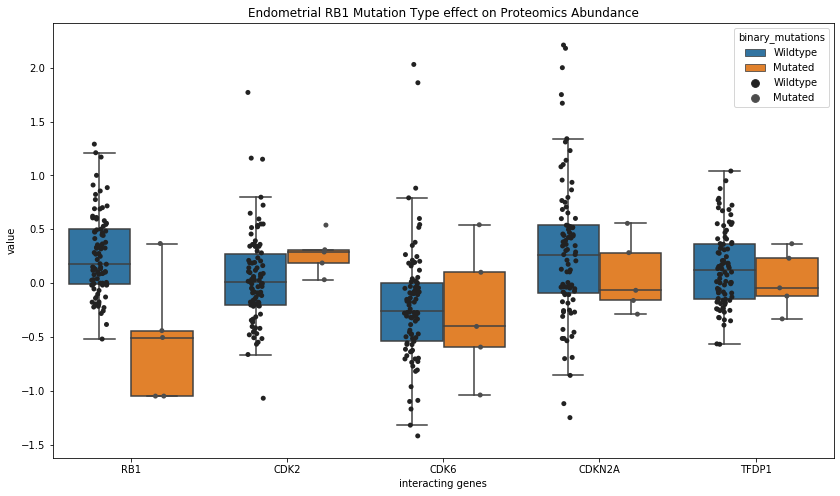

In [30]:
# Visualize
plt.rcParams['figure.figsize']=(14,8) #size of plot
boxplot = sns.boxplot(x='Gene', y="value", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Mutated'], data = RB1_alldf, showfliers = False)    
boxplot.set_title("Endometrial RB1 Mutation Type effect on Proteomics Abundance")
boxplot = sns.stripplot(x='Gene', y="value", hue = 'binary_mutations', data = RB1_alldf, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "interacting genes", ylabel = 'value')

boxplot.set(xlabel = "interacting genes", ylabel = 'value')

plt.show()
plt.clf()
plt.close()


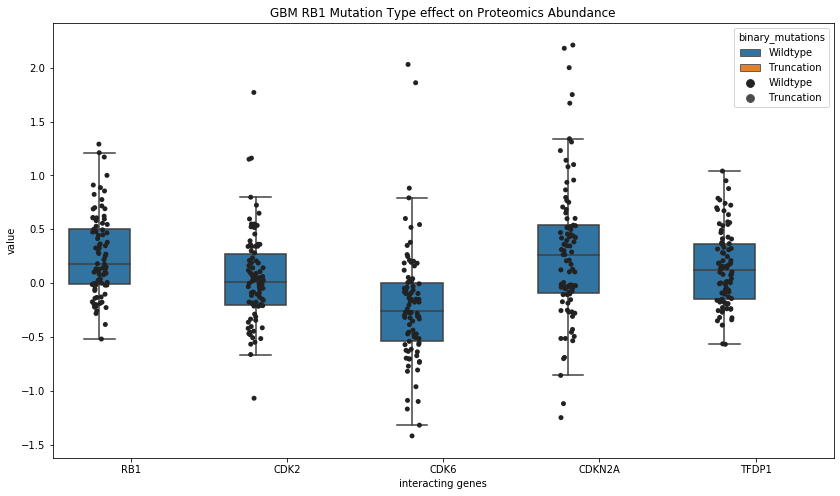

In [31]:
# Visualize
plt.rcParams['figure.figsize']=(14,8) #size of plot
boxplot = sns.boxplot(x='Gene', y="value", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Truncation'], data = RB1_alldf, showfliers = False)    
boxplot.set_title("GBM RB1 Mutation Type effect on Proteomics Abundance")
boxplot = sns.stripplot(x='Gene', y="value", hue = 'binary_mutations', data = RB1_alldf, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "interacting genes", ylabel = 'value')

plt.show()

plt.clf()
plt.close()

In [32]:
# Create Dataframe 

RB1_cis_mut = RB1_prot_miss_trunc_wildtype.assign(Gene= "RB1")
CDK2_trans_mut = CDK2_prot_miss_trunc_wildtype.assign(Gene = "CDK2")
CDK6_trans_mut = CDK6_prot_miss_trunc_wildtype.assign(Gene = "CDK6")
CDKN2A_trans_mut = CDKN2A_prot_miss_trunc_wildtype.assign(Gene = "CDKN2A")
TFDP1_trans_mut = TFDP1_prot_miss_trunc_wildtype.assign(Gene = "TFDP1")
CCND2_trans_mut = CCND2_prot_miss_trunc_wildtype.assign(Gene = "CCND2")


RB1_all = pd.concat([RB1_cis_mut, CDK2_trans_mut, CDK6_trans_mut, CDKN2A_trans_mut,CCND2_trans_mut, TFDP1_trans_mut])
RB1_alldf = pd.melt(RB1_all, id_vars = ["Gene", 'binary_mutations'])
RB1_alldf

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


,Gene,binary_mutations,variable,value
0,RB1,Missense,CCND2_proteomics,NaN
1,RB1,Missense,CCND2_proteomics,NaN
2,RB1,Missense,CCND2_proteomics,NaN
3,RB1,Missense,CCND2_proteomics,NaN
4,RB1,Truncation,CCND2_proteomics,NaN
...,...,...,...,...
3487,TFDP1,Wildtype,TFDP1_proteomics,0.1310
3488,TFDP1,Wildtype,TFDP1_proteomics,-0.2280
3489,TFDP1,Wildtype,TFDP1_proteomics,0.1550
3490,TFDP1,Wildtype,TFDP1_proteomics,0.3660


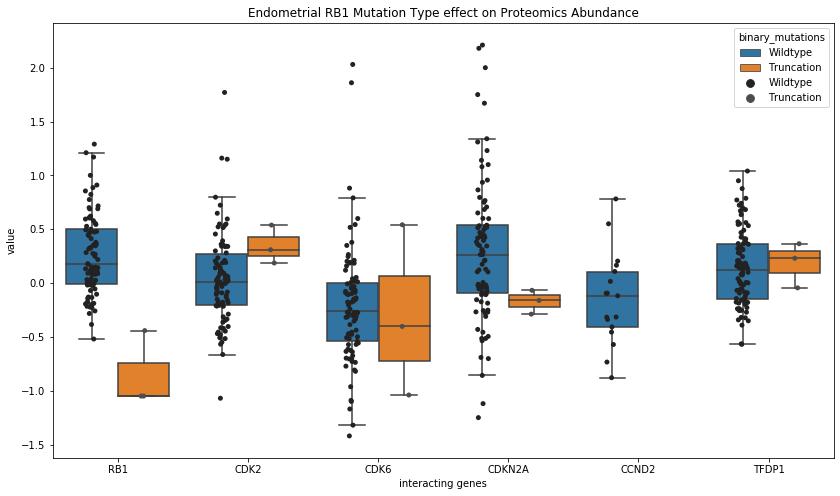

In [33]:
# Visualize
plt.rcParams['figure.figsize']=(14,8) #size of plot
boxplot = sns.boxplot(x='Gene', y="value", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Truncation'], data = RB1_alldf, showfliers = False)    
boxplot.set_title("Endometrial RB1 Mutation Type effect on Proteomics Abundance")
boxplot = sns.stripplot(x='Gene', y="value", hue = 'binary_mutations', data = RB1_alldf, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "interacting genes", ylabel = 'value')

plt.show()

plt.clf()
plt.close()

# Extra checks 

looking for E2F1 in transcriptomics and proteomics 

In [34]:
#num_freq_mut_genes = len(freq_mut)
num_freq_mut_genes = 20
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop 
transrcpt_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'transcriptomics', omics_genes = "E2F1")
reduced_transcript_mutations = brain.reduce_multiindex(transrcpt_mutations, levels_to_drop=1) #single col labels

# Step 2 & 3 - Get binary column and format
transcript_mut_wt = format_mutated_wt_comparison(reduced_transcript_mutations)
transcript_mut_wt

NameError: name 'brain' is not defined

In [ ]:
# Step 4 - T-test
trans_col_list = ['E2F1_transcriptomics']
trans_col = 'E2F1_transcriptomics'

print("Doing t-test comparison for mutation status")
transcript_results = wrap_ttest_return_all(transcript_mut_wt, 'binary_mutations', trans_col_list, num_freq_mut_genes)
transcript_results = transcript_results.rename(index = {0: "Mutated/Wildtype"})
transcript_results

In [ ]:

# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "E2F1") # single col level


# Step 2 & 3 - Get binary column and format
prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
prot_mut_wt.loc[prot_mut_wt ["binary_mutations"] == "Mutated"]

In [ ]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["E2F1"+'_proteomics']
prot_col = "E2F1"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

In [ ]:
df = brain.get_proteomics()
E2_cols = [col for col in df.columns if "CCNA" in col]
print (E2_cols)

In [ ]:
df["E2F3"]

looking for CCNE1

In [ ]:
#num_freq_mut_genes = len(freq_mut)
num_freq_mut_genes = 20
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop 
transrcpt_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'transcriptomics', omics_genes = "CCNA2")
reduced_transcript_mutations = brain.reduce_multiindex(transrcpt_mutations, levels_to_drop=1) #single col labels

# Step 2 & 3 - Get binary column and format
transcript_mut_wt = format_mutated_wt_comparison(reduced_transcript_mutations)
transcript_mut_wt

In [ ]:
# Step 4 - T-test
trans_col_list = ['CCNA2_transcriptomics']
trans_col = 'CCNA2_transcriptomics'

print("Doing t-test comparison for mutation status")
transcript_results = wrap_ttest_return_all(transcript_mut_wt, 'binary_mutations', trans_col_list, num_freq_mut_genes)
transcript_results = transcript_results.rename(index = {0: "Mutated/Wildtype"})
transcript_results

In [ ]:

# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "CCNA2") # single col level


# Step 2 & 3 - Get binary column and format
prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
prot_mut_wt.loc[prot_mut_wt ["binary_mutations"] == "Mutated"]

In [ ]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["CCNA2"+'_proteomics']
prot_col = "CCNA2"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

In [ ]:
df = brain.get_proteomics()
CCN_cols = [col for col in df.columns if "BAK" in col]
print (CCN_cols)


In [ ]:
df.columns.get_loc("CCND1")
df.iloc[0:4,1465:1480]

could not find E2F1 or CCNE1 in proteomics, but were significant in transcriptomics. 

In [ ]:
#num_freq_mut_genes = len(freq_mut)
num_freq_mut_genes = 20
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop 
transrcpt_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'transcriptomics', omics_genes = "CDK2")
reduced_transcript_mutations = brain.reduce_multiindex(transrcpt_mutations, levels_to_drop=1) #single col labels

# Step 2 & 3 - Get binary column and format
transcript_mut_wt = format_mutated_wt_comparison(reduced_transcript_mutations)
transcript_mut_wt

In [ ]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["CDK4"+'_proteomics']
prot_col = "CDK4"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(CDK2_prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

# BIRC5

In [ ]:
#num_freq_mut_genes = len(freq_mut)
num_freq_mut_genes = 20
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop 
transrcpt_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'transcriptomics', omics_genes = "BIRC5")
reduced_transcript_mutations = brain.reduce_multiindex(transrcpt_mutations, levels_to_drop=1) #single col labels

# Step 2 & 3 - Get binary column and format
transcript_mut_wt = format_mutated_wt_comparison(reduced_transcript_mutations)
transcript_mut_wt

In [ ]:
# Step 4 - T-test
trans_col_list = ['BIRC5_transcriptomics']
trans_col = 'BIRC5_transcriptomics'

print("Doing t-test comparison for mutation status")
transcript_results = wrap_ttest_return_all(transcript_mut_wt, 'binary_mutations', trans_col_list, num_freq_mut_genes)
transcript_results = transcript_results.rename(index = {0: "Mutated/Wildtype"})
transcript_results

In [ ]:

# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "BIRC5") # single col level


# Step 2 & 3 - Get binary column and format
prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
prot_mut_wt.loc[prot_mut_wt ["binary_mutations"] == "Mutated"]